In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train = pd.read_csv('/Users/xinqu/Sandbox/CS498 Applied Machine Learning/HW/HW2/train.txt', header = None).values
test = pd.read_csv('/Users/xinqu/Sandbox/CS498 Applied Machine Learning/HW/HW2/test.txt', header = None).values

In [2]:
###label column14
train[np.where(train == ' >50K')] = 1 
train[np.where(train == ' <=50K')] = -1
train = train[:, [0, 2, 4, 10, 11, 12, 14]] ###keep continuous attributes
##scale train data
from sklearn.preprocessing import scale
train[:, 0:-1] = scale(train[:, 0:-1].astype(float), with_mean = True) ###0 mean, 1 std

In [3]:
lambdas = np.array([0.001, 0.01, 0.1, 1])

In [4]:
import random
def train_test_split(data, ratio = 0.1):
    ###return train_data, test_data, split test_data by default ratio = 0.1
    random.shuffle(data)
    train_size = int((1 - ratio) * data.shape[0])
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data
def accuracyscore(x, y):
    return sum(x == np.ravel(y)) / float(len(y))
#train_test_slit(train)
def predict(x, a, b):###predict train data with class label
    result = np.dot(x[:, 0:-1], a.T) + b
    result[result >=0] = 1
    result[result < 0] = -1
    return np.ravel(result)

In [5]:
def SVM(traindata, lamb):
    train_data, test_data = train_test_split(train)
    accuracy_list = []
    magnitude_list = []
    a = np.ones((1, 6))
    b = 1
    held_out_accu = []
    ##50 epochs at least 300 steps
    for epoch in range(50): ### 50 epochs
        steplength = 1 / (0.01 * epoch + 50)
        ###random seperate 50 examples
        held_out_index = set(np.random.choice(train_data.shape[0], size = 50))
        epoch_index = set(range(train_data.shape[0])) - held_out_index
        held_out_index = list(held_out_index)
        held_out = train_data[held_out_index]
        epoch_data = train_data[list(epoch_index)]
        batch_size = 1
        #held_out_accu = []
        for s in range(300):
            ##ramdon choose batch
            batch_index = np.random.choice(held_out.shape[0], batch_size)
            batch_data = held_out[batch_index]
            boundary = np.dot(batch_data[:, -1], (np.dot(batch_data[:, 0:-1], a.T) + b))
            if boundary.item(0) >= 1:
                a = a - steplength * lamb * a
                b = b
            else:
                a = a - steplength * (lamb * a - batch_data[:, 0:-1] * batch_data[:, -1])
                b = b - steplength * (-batch_data[:, -1])
            if s % 30 == 0:
                ###accuracy score of validation set and magnitude every 30 steps
                accuracy_list.append(accuracyscore(predict(test_data, a, b), np.ravel(test_data[:, -1])))
                magnitude_list.append(np.dot(a, a.T).item(0))
                held_out_accu.append(accuracyscore(predict(held_out, a, b), np.ravel(held_out[:, -1])))
    test_accu = accuracyscore(predict(test_data, a, b), np.ravel(test_data[:, -1]))
    return accuracy_list, magnitude_list, a, b, test_accu, held_out_accu

In [6]:
accuracy = []
magnitude = []
a_list = []
b_list = []
test_accu_list = []
held_out = []
for i in lambdas:
    cur_acc, cur_mag, a, b, test_accu, held_out_accu = SVM(train, i)
    accuracy.append(cur_acc)
    magnitude.append(cur_mag)
    a_list.append(a)
    b_list.append(b)
    test_accu_list.append(test_accu)
    held_out.append(held_out_accu)

In [7]:
max(test_accu_list)

0.8002729754322111

In [8]:
test_accu_list = np.array(test_accu_list)
np.amax(test_accu_list), np.argmax(test_accu_list)

(0.8002729754322111, 0)

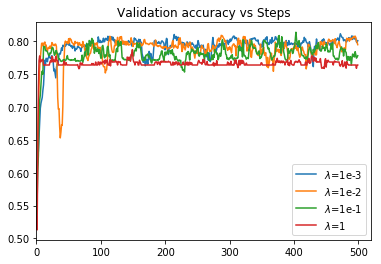

In [9]:
steps = np.arange(500)
plt.figure(1)
for i in range(4):
    plt.plot(steps, accuracy[i])
plt.xlim(0, 520)
plt.legend(['$\lambda$=1e-3', '$\lambda$=1e-2', '$\lambda$=1e-1', '$\lambda$=1'], loc='lower right')
plt.title('Validation accuracy vs Steps')
plt.show()

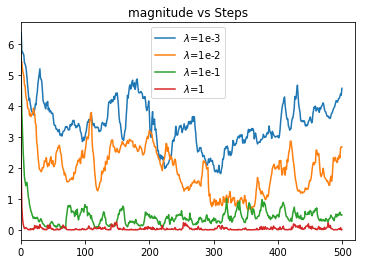

In [10]:
plt.figure(2)
for i in range(4):
    plt.plot(steps, magnitude[i])
plt.xlim(0, 520)
plt.legend(['$\lambda$=1e-3', '$\lambda$=1e-2', '$\lambda$=1e-1', '$\lambda$=1'], loc='best')
plt.title('magnitude vs Steps')
plt.show()

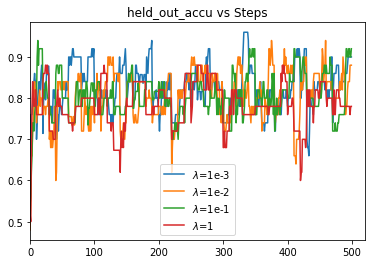

In [12]:
plt.figure(3)
for i in range(4):
    plt.plot(steps, held_out[i])
plt.xlim(0, 520)
plt.legend(['$\lambda$=1e-3', '$\lambda$=1e-2', '$\lambda$=1e-1', '$\lambda$=1'], loc='best')
plt.title('held_out_accu vs Steps')
plt.show()

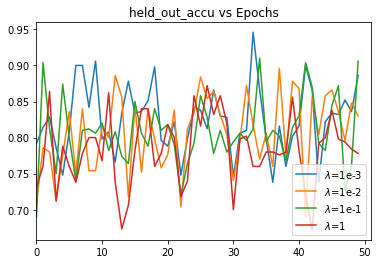

In [18]:
plt.figure(4)
epochstep = np.arange(50)
for i in range(4):
    accuracy[i] = np.array(held_out[i])
    tmp = accuracy[i].reshape((50, 10))
    avg = np.mean(tmp, axis = 1)
    plt.plot(epochstep, avg)
plt.xlim(0, 51)
plt.legend(['$\lambda$=1e-3', '$\lambda$=1e-2', '$\lambda$=1e-1', '$\lambda$=1'], loc='best')
plt.title('held_out_accu vs Epochs')
plt.show()

In [14]:
###find the max accuracy score for validation set in training to find lambda
avg_acc = []
for i in range(4):
    tmp = sum(accuracy[i]) / float(len(accuracy[i]))
    avg_acc.append(tmp)
avg_acc = np.array(avg_acc)
max_avg_acc = np.amax(avg_acc)
max_avg_acc, np.argmax(avg_acc)

(0.7964294813466788, 1)

## The best value of regularization constant is 1e-3

In [13]:
test = test[:, [0, 2, 4, 10, 11, 12]] ###keep continuous attributes
##scale test data
test[:,:] = scale(test.astype(float), with_mean = True) ###0 mean, 1 std

In [14]:
def predicty(y, a, b):###predict data without class label
    result = np.dot(y, a.T) + b
    result[result >=0] = 1
    result[result < 0] = -1
    return np.ravel(result)
test_y_pred = predicty(test, a_list[0], b_list[0])

In [15]:
from collections import Counter
Counter(test_y_pred)

Counter({-1: 4011, 1: 874})

In [16]:
test_y_class = []
for i in range(len(test_y_pred)):
    if test_y_pred[i] == 1:
        test_y_class.append('>50K')
    else:
        test_y_class.append('<=50K')
with open('submission.txt', 'w') as f:
    for item in test_y_class:
        f.write("%s\n" % item)
###accuracy score 81.92

In [17]:
a_list[0], b_list[0]

(array([[0.5591821288618918, 0.0674129005101583, 0.8178490681723566,
         1.7899841775715828, 0.3788290681493343, 0.24920087312729983]],
       dtype=object), array([-1.019472612512635], dtype=object))